<a href="https://colab.research.google.com/github/Coreight98/Paran_ajou_Project_Anything/blob/main/Image_Pattern_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
GoogleNet = models.googlenet(pretrained=True)
GoogleNet.fc = nn.Linear(in_features=1024, out_features=38)
GoogleNet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import PIL
import time
from sklearn.neighbors import KNeighborsClassifier
import random
import torch

Mounted at /content/drive


In [56]:
train_location = './drive/MyDrive/data/DTD/'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

class PatternDataset():
    def __init__(self, image, mode, transforms):
        super().__init__()
        self.image = image
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index):
        image_name = self.image[index]
        image = Image.open(train_location + image_name)
        image = image.resize((224,224))
        #레이블 입력
        label = 1
        label = torch.tensor(label,dtype=torch.long)
        #이미지 변형 적용용
        image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.image)
    def ind(index):
      image=self.image[index]
      return image

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def train(trainloader, net, criterion, optimizer):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):
      inputs, labels = data  # data입력
      optimizer.zero_grad()  # gradient 매개변수를 0으로 만듬
      # 순전파 + 역전파 + 최적화
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # 통계출력
      running_loss += loss.item()
      if i % 16 == 15:
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0

def test(testloader, net):
  # 전체 데이터 셋에 대한 결과 확인
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the 380 test images: %d %%' % (100*correct/total))

In [57]:
# 랜덤 시드 고정


net=GoogleNet
net.load_state_dict(torch.load('./drive/MyDrive/data/DTD_save/YG/GoogleNet_weights/GoogleNet_weights_17.pth'))
net.eval()
X = np.load('./drive/MyDrive/data/DTD_save/DTD3.npy')
X = np.reshape(X,(4180,38))
Y = np.zeros((4180,1))
# Y = np.reshape(Y,(4180,1))
reg = KNeighborsClassifier(n_neighbors=4)
reg.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [58]:
if __name__ == '__main__':
    SEED = 777
    seed_everything(SEED)
    #데이터 셋 불러오고 정규화
    transform = transforms.Compose(
        [transforms.ToTensor(),
          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
          ]
    )
    train_images = os.listdir(train_location)
    train_dataset = PatternDataset(train_images, mode='train', transforms=transform)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4180, shuffle=False, num_workers=0)

    img = PIL.Image.open('./drive/MyDrive/data/DTD/banded_0002.jpg')
    img = img.resize((224,224))
    emp = torch.empty(1,3,224,224)
    img_t =transform(img)
    emp[0] = img_t
    input = net(emp)
    neighbor_index= reg.kneighbors(input.detach().numpy(),n_neighbors=4,return_distance=False)
    # print(neighbor_index)
    neighbor_index.sort()

    # for i in neighbor_index:
    #       temp = np.empty((0,38),dtype=int)
    #       temp = np.append(temp, X[i])
    #       temp = np.reshape(temp,(4,38))
    
    id=0
    img = torch.empty((4,3,224,224))
    for ind in neighbor_index[0]:
      # print(train)
      img[id][0] = train_dataset[ind][0][0]
      id+=1

In [36]:
from IPython.display import Image 
for ind in neighbor_index[0]:
  print(train_images[ind])
  # name='./drive/MyDrive/data/DTD/%s'%(train_images[ind])
  # img=Image(name)
  # display(img)
  # print(name)
from PIL import Image

flecked_0137.jpg
lacelike_0054.jpg
bubbly_0043.jpg
bubbly_0069.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


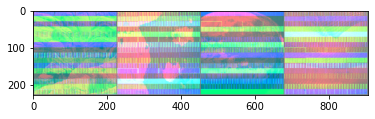

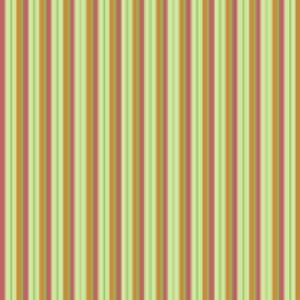

In [59]:
 #이미지 출력
imshow(torchvision.utils.make_grid(img))
# plt.imshow(img)
from IPython.display import Image 
img=Image('./drive/MyDrive/data/DTD/banded_0002.jpg')
display(img)
from PIL import Image